In [3]:
import numpy as  np
import PerlinNoise as pn
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import time

Init time: 0.0010008811950683594


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


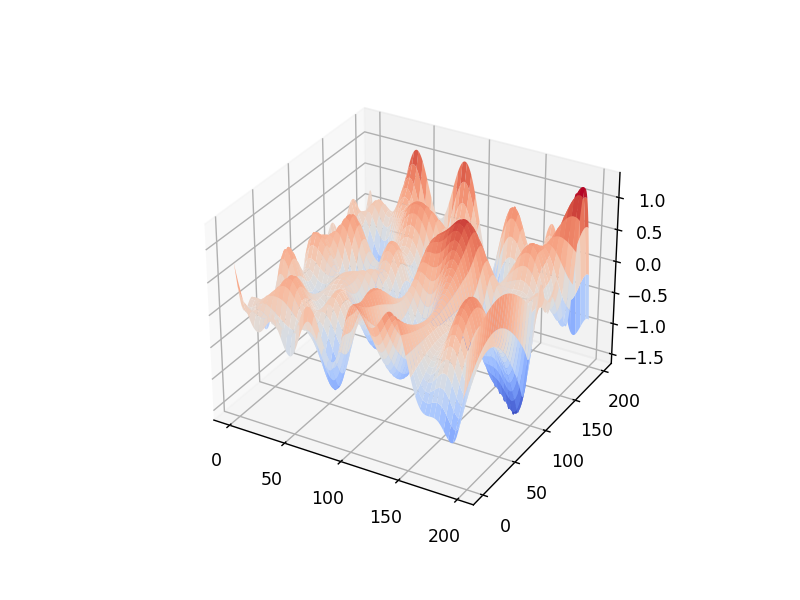

size of compression: 20 Compression ratio: 2000.0 
Compression time: 11.944453954696655
error: 0.34740332060996787


<IPython.core.display.Javascript object>

Decompression time: 0.24500632286071777


In [4]:
'''
    This compression approach models the landscape as composed of localised function (e.g gaussian distributions)
    which can be independently identified within the elevation model. This leads to a sparse representation of the data,
    where a raster representation would mostly yield zero values. This has particular gains when treating each function
    and it's parameters as a vector, hence removing all the zero values. 
    
    Additionally, the use of datastructures can lead to efficient access of regional data given that the data only has a 
    limited area of effect (e.g 3 std for gaussian distributions). The localised functions can also be ranked by internal 
    volume to dynamically reduce the precision of data loaded, allow gradual reconstruction and allow for scalability over
    large areas.
    
    Pros:
        * -Very small decompresison time
        * -Stored datapoints are independent of eachother
        * -Efficient data access given efficient data structures
        * -Allows gradual construction
        * -Allows variable precision to a point
        * -Allows megahectare scale provided an efficient search algorithm
        * -Allows for different base functions
        * -Database can be gradually decomposed (ie, inplace modification memory + linear compressed data creation)
            where the remaining is similar to current compression error
        * -Localised functions have a small area of effect (by definition)
        * -Compression rate depends on the information of the data
    Cons:
        * -Large compression time
        * -Rounding errors
        * -Some landforms are difficult to express as the addition of multiple functions (e.g plains)
        * -Race conditions and thread conflicts mean that more care has to be taken when parrelising
        * -Use of scipy.minimise (gradient descent) may lead to suboptimal solutions (due to local minima)
    
    
'''
class SparseLocalisedFunctions:
    # the stored parameters for the sparse representation (the compressed form)
    sparse_funcs = []
    
    def __init__(self, img, epsilon = 0.01, max_iter = 1000):
        self.img = img
        self.pixels = np.prod(img.shape)
        self.epsilon = epsilon
        self.x,self.y = np.meshgrid(np.arange(img.shape[0]),np.arange(img.shape[1]))
        self.max_iter = max_iter
        self.orig = copy.deepcopy(img)
        
    # The base, localised function (here a gaussian curve)
    def gaussian_2D(self, theta, x, y):
        mu1, mu2, std1, std2, c = theta
        return c*np.exp(-1/std1*(x-mu1)**2-1/std2*(y-mu2)**2)
    
    # deconstruct the image/elevation data and add parameters to sparse_funcs (the compressed form)
    def decompose(self):
        count = 0
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(self.x,self.y,self.img, cmap = cm.coolwarm)
        #plt.plot()
        while np.abs(self.img).sum()/self.pixels > self.epsilon and count < self.max_iter:
            mu2, mu1 = np.array(np.where(np.absolute(self.img) == np.max(np.absolute(self.img))))[:,0]
            maxim = self.img[mu1, mu2]
            #print(mu1, mu2, maxim)
            theta0 = [mu1, mu2, self.img.shape[0]/1,self.img.shape[1]/1,maxim]
            # changing the following to be more localised would increase speed
            result = opt.minimize(lambda theta: np.abs(self.img-self.gaussian_2D(theta, self.x, self.y)).sum(), theta0)
            self.img -= self.gaussian_2D(result.x, self.x, self.y)
            self.sparse_funcs.append(result.x)
            #print(np.abs(self.img).sum(), result.x)
            count += 1
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(self.x,self.y,self.img, cmap = cm.coolwarm)
        print(f"size of compression: {len(self.sparse_funcs)} Compression ratio: {self.pixels/len(self.sparse_funcs)} ")
        #plt.plot()
    
    # reconstruct the image/elevation data given sparse_funcs (the compressed form)
    def compose(self):
        self.img *= 0
        for func in self.sparse_funcs:
            self.img += self.gaussian_2D(func, self.x, self.y)
        print(f"error: {np.abs(self.orig-self.img).sum()/self.pixels}")
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(self.x,self.y,self.img, cmap = cm.coolwarm)
    
# Testing code
img_dims = np.array((200,200))
noise = pn.PerlinNoise(img_dims)
noise.generate_fractal([100],[20])
time1 = time.time()
SLF = SparseLocalisedFunctions(noise.noise, max_iter = 20)
print(f"Init time: {time.time()-time1}")
time1 = time.time()
SLF.decompose()
print(f"Compression time: {time.time()-time1}")
time1 = time.time()
SLF.compose()
print(f"Decompression time: {time.time()-time1}")